Text(0.5, 1.0, 'Scanned Form')

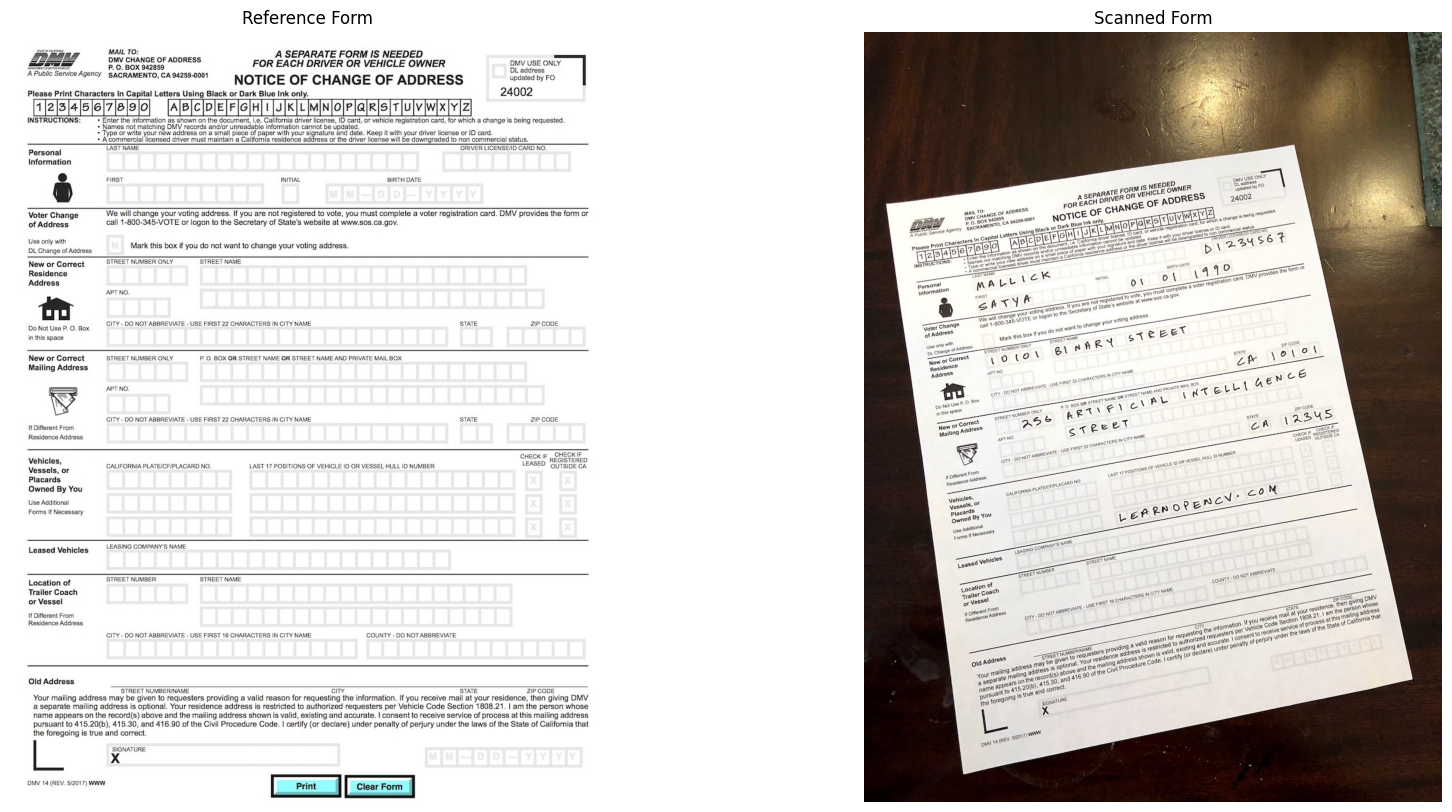

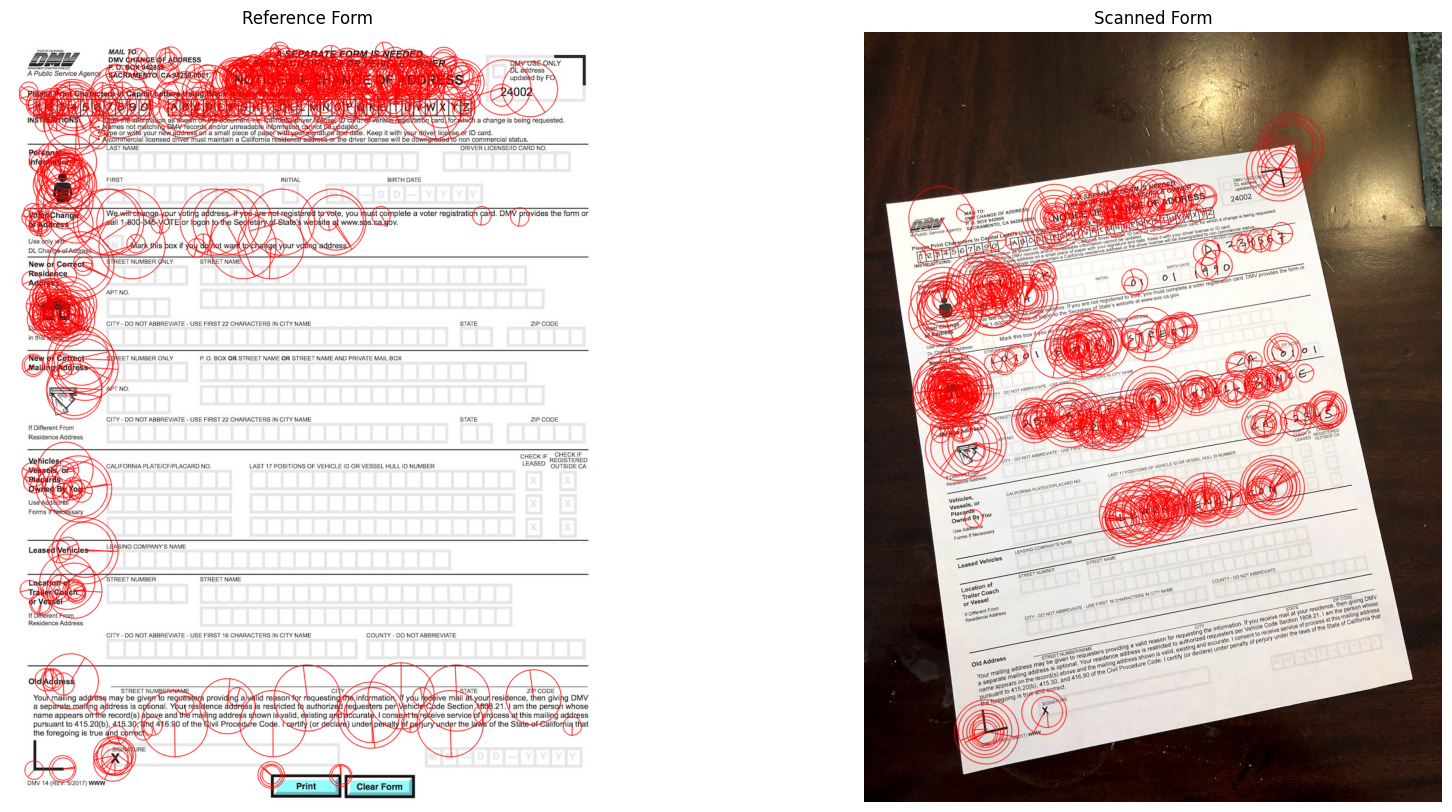

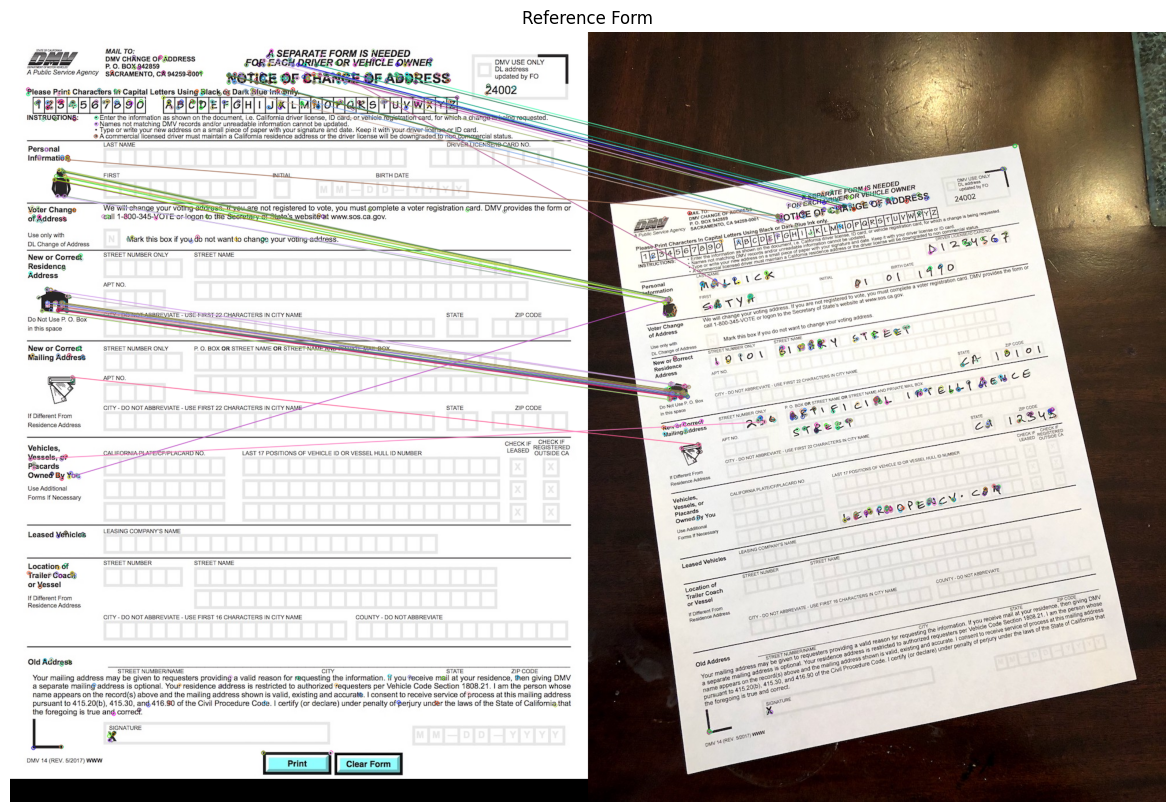

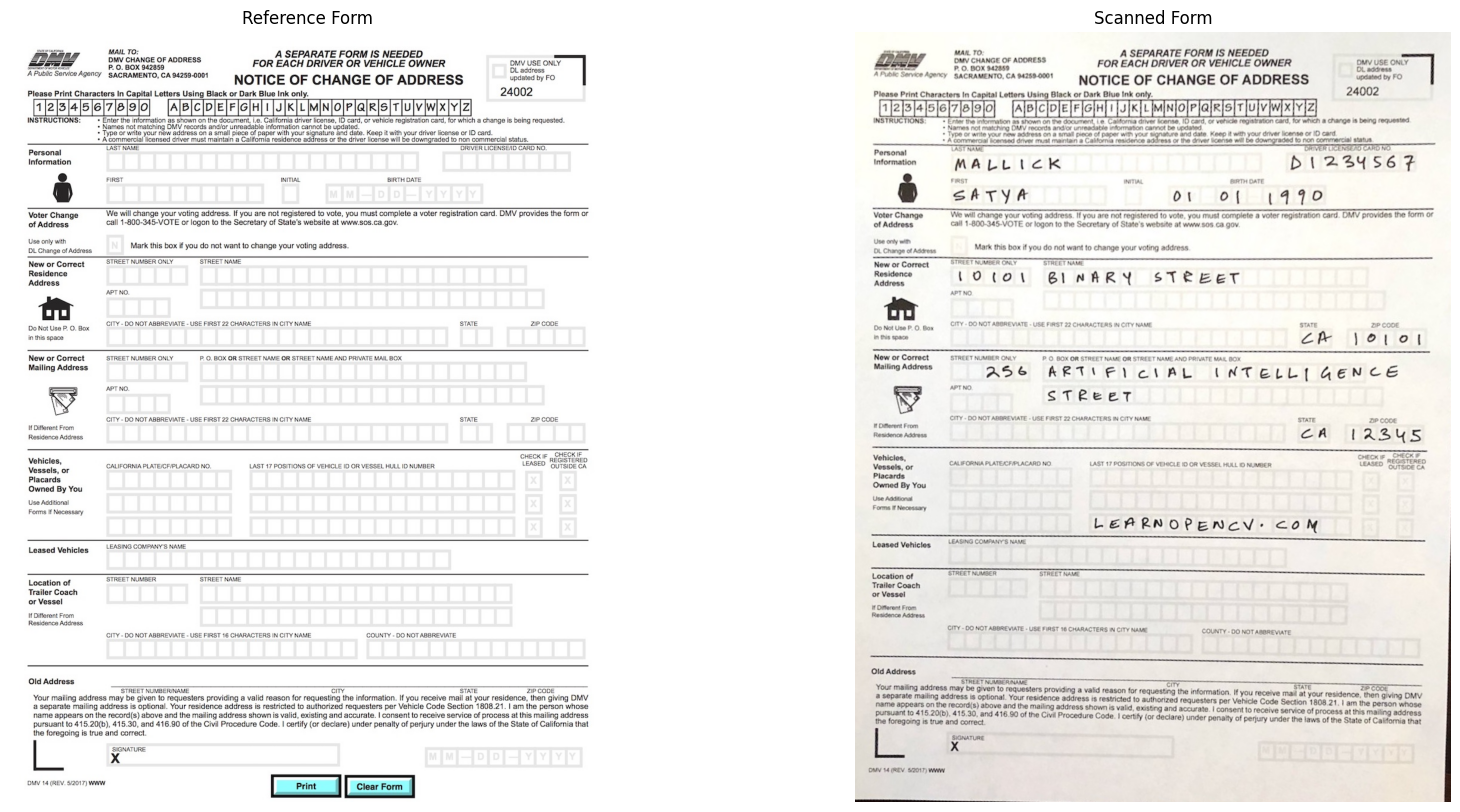

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

## READ THE REFERENCE AND SCANNED IMAGE ##
# Read reference image
ref_img = cv2.imread('form.jpg', cv2.IMREAD_COLOR)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

# Read image to be aligned
scanned_img = cv2.imread('scanned-form.jpg', cv2.IMREAD_COLOR)
scanned_img = cv2.cvtColor(scanned_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[20, 10])
plt.subplot(121)
plt.axis('off')
plt.imshow(ref_img)
plt.title('Reference Form')

plt.subplot(122)
plt.axis('off')
plt.imshow(scanned_img)
plt.title('Scanned Form')

# Convert images to grayscale
ref_img_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
scanned_img_gray = cv2.cvtColor(scanned_img, cv2.COLOR_BGR2GRAY)


# Detect Oriented FAST and Rotated BRIEF (ORB) features and compute descriptors / keypoints
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
# keypoints are points in the image that are interesting or distinctive such as corners or blobs
# descriptors are usually vectors that represent keypoints, used to match keypoints between images
# None could be a mask instead
keypoints1, descriptors1 = orb.detectAndCompute(ref_img_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(scanned_img_gray, None)

# Display the keypoints as circles with flags
ref_img_display = cv2.drawKeypoints(ref_img, keypoints1, outImage=np.array([]), color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
scanned_img_display = cv2.drawKeypoints(scanned_img, keypoints2, outImage=np.array([]), color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.axis('off')
plt.imshow(ref_img_display)
plt.title('Reference Form')

plt.subplot(122)
plt.axis('off')
plt.imshow(scanned_img_display)
plt.title('Scanned Form')

# Match features, start by making a description matcher object
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by distance
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches, top 10% are retained with 0.1
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

# Draw the top matches
im_matches = cv2.drawMatches(ref_img, keypoints1, scanned_img, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches)
plt.axis('off')
plt.title('Reference Form')

# Extract the coordinates of good matches

# np.zeros creates an array filled with zeros
# (len(matches), 2) is a tuple specifying the shape of the array being created and 2 says each match will have two coordinates
# So if there are 20 matches, the array will have 20 rows and 2 columns
# Homograph expects floating point numbers so you need dtype explicitly stated
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

# enumerate(matches) returns both the index i and the match object match for each iteration
for i, match in enumerate(matches):
    # match.queryIdx is the index of the keypoint in keypoints1 that corresponds to the current match
    # keypoints1[match.queryIdx].pt retrieves the (x, y) coordinates of this keypoint
    # points1[i, :] assigns these coordinates to the i-th row of points1
    # no colon would mean you'd have to assign each coordinate individually which takes more time
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
# computes the homography matrix h that maps points from the scanned image to the reference image
# cv2.RANSAC is the algorithm used to robustly estimate the homography matrix, which helps to ignore outliers
# h is the homography matrix while the mask is a mask indicating which points were considered inliers (not outliers)
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography to warp image
# warpPerspective applies a perspective transformation to the scanned image using the homography matrix h
height, width, channels = ref_img.shape
scanned_img_reg = cv2.warpPerspective(scanned_img, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121)
plt.imshow(ref_img)
plt.axis('off')
plt.title('Reference Form')

plt.subplot(122)
plt.imshow(scanned_img_reg)
plt.axis('off')
plt.title('Scanned Form')